In [1]:
import pandas as pd
import numpy as np
import time
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as rng
import re
from scipy.stats import qmc
from mpl_toolkits.mplot3d import Axes3D
from itertools import product, combinations

caminho_do_projeto = r'C:\Users\kmenezes\OneDrive - unb.br\tcc_organizacao'

if caminho_do_projeto not in sys.path:
    sys.path.insert(0, caminho_do_projeto)
from projeto_aplicado.modelos.otimizador_pli import OtimizadorPLI
from projeto_aplicado.modelos.otimizador_aco import OtimizadorACO
from projeto_aplicado.modelos.otimizador_ag import OtimizadorAG
from projeto_aplicado.modelos.otimizador_base import Otimizador
from projeto_aplicado.modelos.analisador import AnalisadorDeSolucao
base = r"C:\\Users\\kmenezes\\OneDrive - unb.br\\tcc_organizacao\\dados"

# Configurações de visualização
sns.set_theme(style="whitegrid")
pd.set_option('display.max_rows', 100)

In [2]:
CONFIG_BASE = {
    "ARQUIVOS_DADOS": {
        "disciplinas": "disciplinas.csv",
        "professores": "docentes.csv",
        "preferencias": "preferencias.csv",
        "conflitos": "matriz_conflitos.csv" 
    },
    "ALOCACOES_FIXAS": [
    ]
}

CONFIG_BASE_ADAPTADA ={
    "ALOCACOES_FIXAS": [
    ]
}

# Parâmetros específicos para cada algoritmo
CONFIG_PLI = {
    **CONFIG_BASE,
    "PENALIDADE_W": 4.0
}

CONFIG_PLI_ADAPTADA = {

    "PENALIDADE_W": 4.0
}

CONFIG_ACO = {
    **CONFIG_BASE,
    "ACO_PARAMS": {
        "n_geracoes": 100,
    }
}

CONFIG_AG = {
    **CONFIG_BASE,
    "AG_PARAMS": {
        "n_geracoes": 300,
        "fator_penalidade": 10,
    }
}
analise = AnalisadorDeSolucao(config=CONFIG_BASE)
otimizador = Otimizador(config=CONFIG_BASE)
d1 = otimizador.dados_brutos
prof = d1['professores']
disc = d1['disciplinas']
conf = d1['conflitos']
pref = d1['preferencias']

df = pd.DataFrame()

In [3]:
def lhs_aco_params(n_amostras=10, seed=None):
    """
    Gera amostras de parâmetros para o algoritmo ACO usando Latin Hypercube Sampling (LHS).
    """    
    limites_inferiores = [10, 0.1, 1, 0.01]  # n_formigas, alfa, beta, taxa_evaporacao
    limites_superiores = [100, 5, 10, 0.6]
    sampler = qmc.LatinHypercube(d=len(limites_inferiores), seed=seed)
    sample = sampler.random(n_amostras)
    l_bounds = np.array(limites_inferiores)
    u_bounds = np.array(limites_superiores)
    amostras = qmc.scale(sample, l_bounds, u_bounds)
    cols = ["n_formigas", "alfa", "beta", "taxa_evaporacao"]
    df_params = pd.DataFrame(amostras, columns=cols)
    df_params["n_formigas"] = df_params["n_formigas"].round().astype(int)
    df_params["simulacao"] = df_params.index + 1
    return df_params

In [4]:
def lhs_ag_params(n_amostras=10, seed=None):
    """
    Gera amostras de parâmetros para o algoritmo AG usando Latin Hypercube Sampling (LHS).
    """    
    limites_inferiores = [30, 0.5, 0.0, 3, 0]  # n_populacao, taxa_crossover, taxa_mutacao, tamanho_torneio, pct_elite
    limites_superiores = [300, 0.9, 0.3, 15, 0.4]
    sampler = qmc.LatinHypercube(d=len(limites_inferiores), seed=seed)
    sample = sampler.random(n_amostras)
    l_bounds = np.array(limites_inferiores)
    u_bounds = np.array(limites_superiores)
    amostras = qmc.scale(sample, l_bounds, u_bounds)
    cols = ["n_populacao", "taxa_crossover", "taxa_mutacao", "tamanho_torneio", "elit_pct"]
    df_params = pd.DataFrame(amostras, columns=cols)
    df_params["n_populacao"] = df_params["n_populacao"].round().astype(int)
    df_params["tamanho_torneio"] = df_params["tamanho_torneio"].round().astype(int)
    df_params["simulacao"] = df_params.index + 1
    return df_params

In [5]:
#Gerando Dataframe Final
tamanho, seed = 1000, 42
lhs_global = pd.merge(lhs_aco_params(tamanho, seed=seed), lhs_ag_params(tamanho, seed=seed), on='simulacao')

lhs_global.to_csv('novo_lhs_simulacoes.csv', index=False)

In [5]:
#Gerando Dataframe Final
tamanho, seed = 100, 42
lhs_estudo_convergencia = pd.merge(lhs_aco_params(tamanho, seed=seed), lhs_ag_params(tamanho, seed=seed), on='simulacao')

#lhs_estudo_convergencia.to_csv('estudo_convergencia.csv', index=False)

In [9]:
lhs_estudo_convergencia['n_formigas'] = 30
lhs_estudo_convergencia['taxa_evaporacao'] = .1
lhs_estudo_convergencia['alfa'] = 1.5
lhs_estudo_convergencia['beta'] = 8
lhs_estudo_convergencia['n_populacao'] = 100
lhs_estudo_convergencia['elit_pct'] = 0.15
lhs_estudo_convergencia['taxa_crossover'] = 0.7
lhs_estudo_convergencia['taxa_mutacao'] = 0.05
lhs_estudo_convergencia['tamanho_torneio'] = 10

lhs_estudo_convergencia.to_csv('simulacao_robustez.csv', index=False)

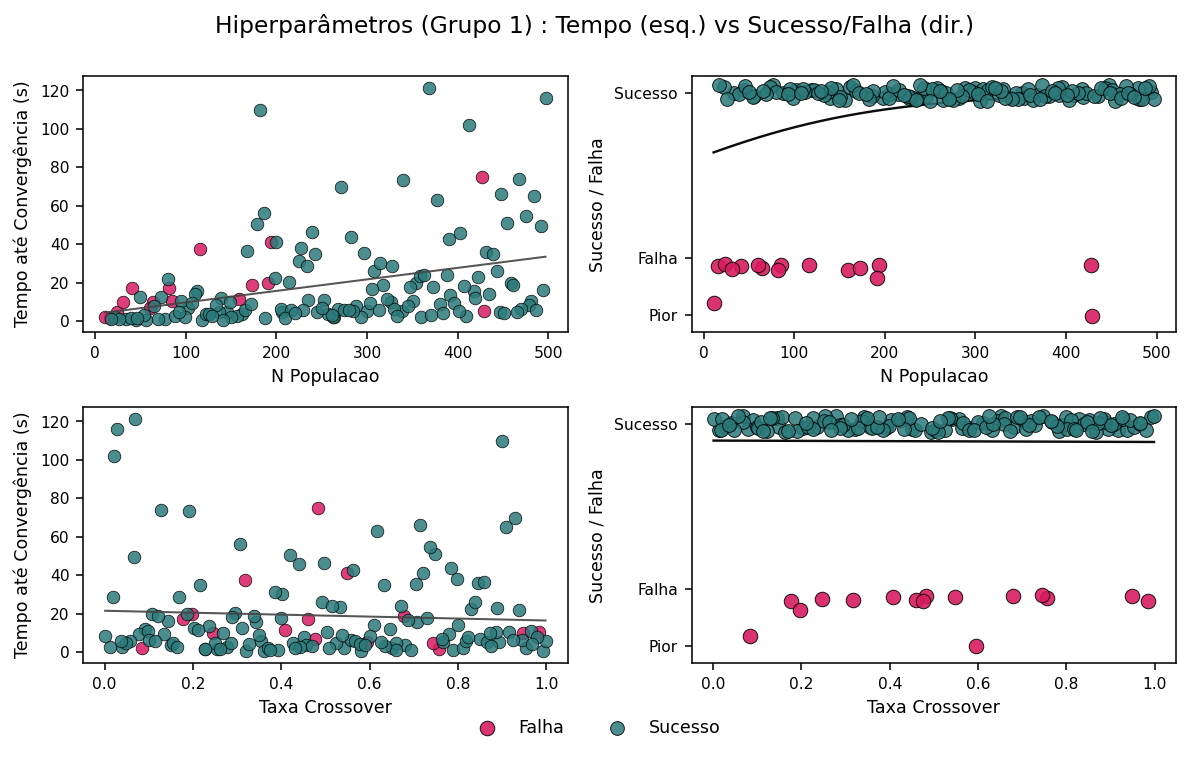

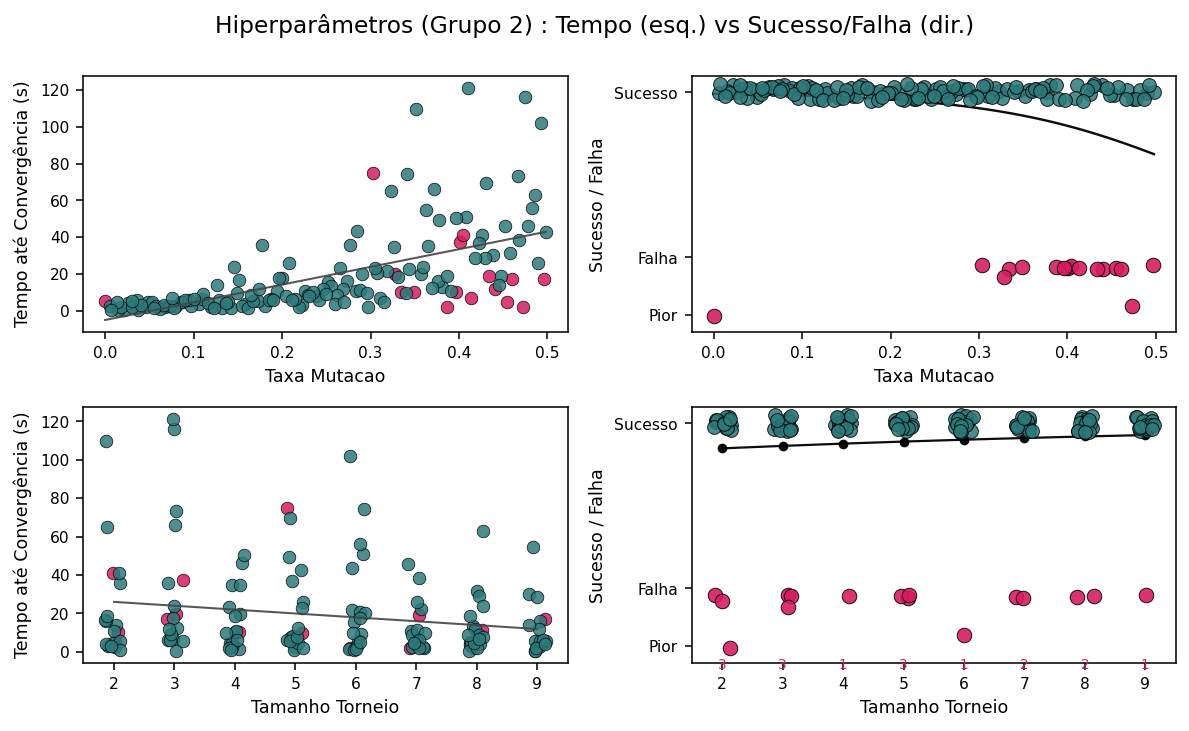

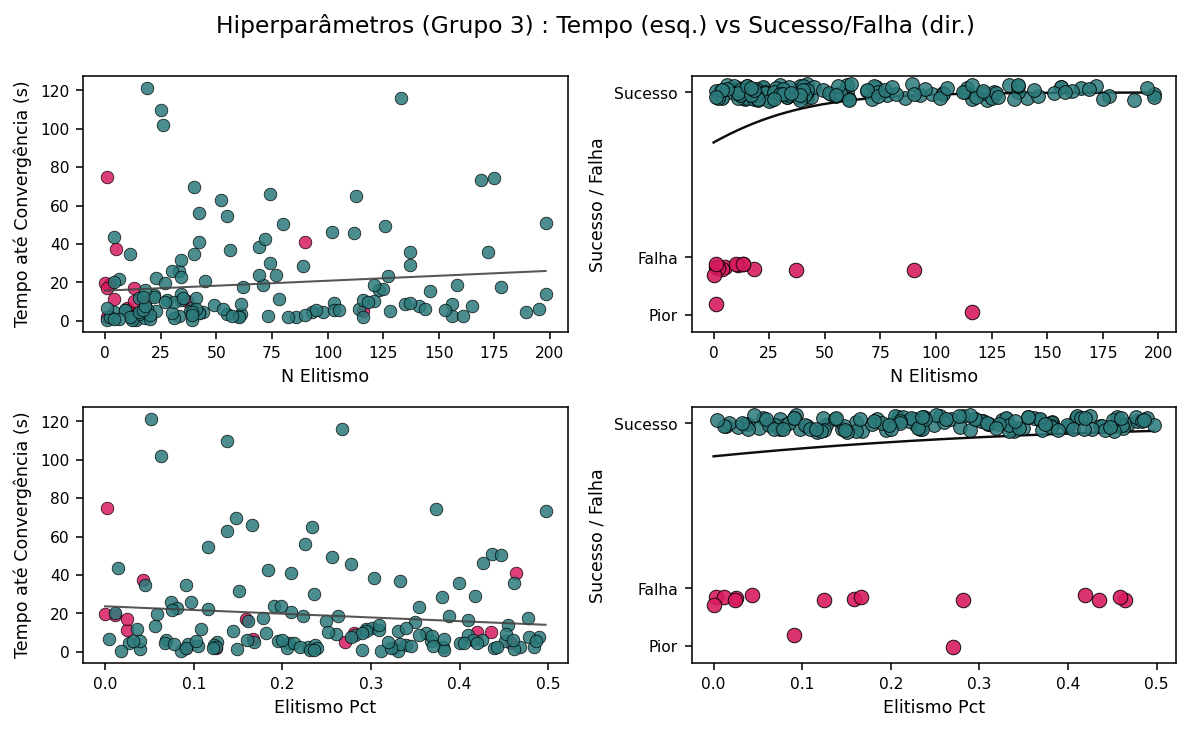

In [3]:

analise = AnalisadorDeSolucao(config=CONFIG_BASE)
otimizador = Otimizador(config=CONFIG_BASE)
d1 = otimizador.dados_brutos
prof = d1['professores']
disc = d1['disciplinas']
conf = d1['conflitos']
pref = d1['preferencias']


perturbacao_preferencias = 0.2
perturbacao_horarios = 0.2
seed = 211028972

def log_msg(mensagem):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{timestamp}] {mensagem}")

#Criando matriz de conflitos
def parse_horario(horario_str):
    """
    Interpreta uma string de horário no formato '24M12' e a converte
    em um dicionário estruturado.

    Args:
        horario_str (str): A string de horário (ex: '35T34', '6N12', etc.).

    Returns:
        dict: Um dicionário com os dias, turno e horários, ou None se o formato for inválido.
    """
    # Expressão regular para capturar os 3 componentes: dias, turno, blocos
    match = re.match(r'(\d+)([MTN])(\d+)', horario_str)
    
    if not match:
        return None # Formato inválido

    dias_str, turno_char, blocos_str = match.groups()

    mapa_dias = {'2': 'SEG', '3': 'TER', '4': 'QUA', '5': 'QUI', '6': 'SEX'}
    
    # Converte os dígitos dos dias em um conjunto de strings (ex: {'SEG', 'QUA'})
    dias_set = {mapa_dias[dia] for dia in dias_str if dia in mapa_dias}
    
    # Converte os dígitos dos blocos em um conjunto de inteiros (ex: {1, 2})
    blocos_set = {int(bloco) for bloco in blocos_str}

    return {
        'dias': dias_set,
        'turno': turno_char,
        'blocos': blocos_set
    }

def verificar_conflito(horario_str1, horario_str2):
    """
    Verifica se duas strings de horário entram em conflito.

    Args:
        horario_str1 (str): Horário da primeira disciplina.
        horario_str2 (str): Horário da segunda disciplina.

    Returns:
        bool: True se houver conflito, False caso contrário.
    """
    h1 = parse_horario(horario_str1)
    h2 = parse_horario(horario_str2)

    if h1 is None or h2 is None:
        print(f"Aviso: Formato de horário inválido encontrado ({horario_str1} ou {horario_str2})")
        return False

    # 1. Verifica se os turnos são diferentes (se forem, não há conflito)
    if h1['turno'] != h2['turno']:
        return False

    # 2. Verifica se há intersecção de dias da semana
    dias_em_comum = h1['dias'].intersection(h2['dias'])
    if not dias_em_comum:
        return False

    # 3. Verifica se há intersecção de blocos de horário
    blocos_em_comum = h1['blocos'].intersection(h2['blocos'])
    if not blocos_em_comum:
        return False

    # Se passou por todas as verificações, significa que há conflito
    return True


def criar_matriz_conflitos(disciplinas_df):
    """
    Cria uma matriz de conflitos entre disciplinas com base nos horários.
    
    Args:
        disciplinas_df (pd.DataFrame): DataFrame com colunas 'id_disciplina' e 'horario'
    
    Returns:
        pd.DataFrame: Matriz de conflitos (0 = sem conflito, 1 = com conflito)
    """
    disciplinas = disciplinas_df['id_disciplina'].tolist()
    horarios = disciplinas_df.set_index('id_disciplina')['horario'].to_dict()
    num_disciplinas = len(disciplinas)
    matriz_conflitos = pd.DataFrame(0, index=disciplinas, columns=disciplinas)
    
    for i in range(num_disciplinas):
        for j in range(i, num_disciplinas):
            disc1 = disciplinas[i]
            disc2 = disciplinas[j]
            
            # Não compara uma disciplina com ela mesma
            if i == j:
                continue
                
            if verificar_conflito(horarios[disc1], horarios[disc2]):
                matriz_conflitos.loc[disc1, disc2] = 1
                matriz_conflitos.loc[disc2, disc1] = 1
    
    return matriz_conflitos

def normalizar_probabilidades(p):
    """
    Ajusta um vetor de probabilidades para ser válido:
    - todos positivos
    - soma exatamente 1
    metodo:
      - "clip": zera negativos e normaliza
    """
    p = np.asarray(p, dtype=float)


    # Estável numericamente
    p = np.clip(p, 0, None)
    s = p.sum()
    return p / s if s > 0 else np.full_like(p, 1.0 / len(p))

#Função que perturba preferencias
def perturbar_preferencias(df_preferencias, df_disciplinas,  seed=None):
    """
    Altera as preferencias forma aleatória.
    
    Parameters:
    -----------
    df_preferencias : pd.DataFrame
        DataFrame contendo pelo menos a coluna 'preferencia'
    proporcao_perturbacao : float
        Proporção de preferências a serem alteradas (0 a 1)
    seed : int, optional
        Seed para reprodutibilidade
        
    Returns:
    --------
    pd.DataFrame
        DataFrame com as preferências perturbadas
    """
    if seed is not None:
        rng.seed(seed)
    
    #Calcula o número de turmas por disciplina
    turmas_disc = df_disciplinas[['id_disciplina', 'disciplina']]\
        .merge(df_disciplinas.groupby('disciplina').agg({'id_disciplina':'count'}).rename(columns={'id_disciplina':'n_turmas'}).reset_index(), on='disciplina', how='left')\
            .copy()
    
    #Cria o dataframe que será alterado
    df_result = df_preferencias.copy()
    proporcao_perturbacao = min(max(rng.normal(.15, .1), 0), 1)
    opcoes = [0, 1, 2, 3]
    prob_original = [0.43, 0.21, 0.07, 0.29]
    probabilidades = normalizar_probabilidades(prob_original + rng.normal(loc=0, scale=.09, size=4))
    n_alteracoes = int(len(df_result) * proporcao_perturbacao)
    
    try:
        escolhas = rng.choice(opcoes, 
                          size=n_alteracoes,
                          replace=True,
                          p=probabilidades)
    except:
        escolhas = rng.choice(opcoes, 
                          size=n_alteracoes,
                          replace=True,
                          p=prob_original)
    
    indices_aleatorios = df_result.sample(n = n_alteracoes).index
    df_result.loc[indices_aleatorios, 'preferencia'] = escolhas
    
    #Calcula métricas de variacao de preferências
    #Calcula numero de professores interessados por turma
    analise = df_result[df_result['preferencia'] ==3].groupby('id_disciplina').agg({'id_docente':'count'}).reset_index().rename(columns={'id_docente':'n_professores_interessados'})
    #Adiciona numero de turmas por disciplina
    analise = analise.merge(turmas_disc, on='id_disciplina', how='outer')
    #Calcula a media de professores interessados por disciplina
    analise = analise.groupby(['disciplina']).agg({'id_disciplina':'first', 'n_professores_interessados':'mean', 'n_turmas':'first'}).reset_index()
    #Calcula interessados por turma
    analise['interesados_por_turma'] = analise['n_professores_interessados'] / analise['n_turmas']
    #Calcula global de interessados por turma
    n_interessados_por_turma = analise['interesados_por_turma'].mean()
    metricas = {
        'proporcao_perturbacao': proporcao_perturbacao,
        'n_interessados_por_turma': n_interessados_por_turma
    }

    return metricas, df_result


def perturbar_horarios(df_disciplinas, seed=None):
    """
    Perturba os horários das disciplinas selecionando aleatoriamente novas opções 
    com base na distribuição de frequência existente para cada par (Carga Horária, Tipo).
    
    A função:
    1. Calcula a distribuição de probabilidade dos horários atuais.
    2. Sorteia uma proporção variável de disciplinas para alterar.
    3. Para cada disciplina selecionada, escolhe um novo horário compatível, 
       adicionando um ruído estocástico às probabilidades originais para garantir variabilidade.
    4. Recalcula a matriz de conflitos e retorna o saldo (delta) em relação ao estado original.

    Parameters:
    -----------
    df_disciplinas : pd.DataFrame
        DataFrame contendo as disciplinas com colunas 'horario', 'carga_horaria' e 'tipo_disciplina'.
    seed : int, optional
        Seed para reprodutibilidade do gerador de números aleatórios.
        
    Returns:
    --------
    tuple
        (metricas: dict, matriz_conflitos_perturbada: pd.DataFrame)
        Onde 'metricas' contém o número de mudanças e o saldo de conflitos gerados/resolvidos.
    """
    if seed is not None:
        rng.seed(seed)
    
    df_result = df_disciplinas.copy()
    #Calcula as probabilidades de cada horario baseado na carga horaria e tipo de disciplina
    probs = df_result[['carga_horaria', 'tipo_disciplina', 'horario']].value_counts(normalize=True)
    #Seleciona aleatoriamente uma proporção de disciplinas para alterar o horario
    proporcao_alteracoes = min(max(rng.normal(0.2, .2, 1 ), 0), 1)
    indices_escolhidos = df_result.sample(frac=float(proporcao_alteracoes)).index
    
    for indice in indices_escolhidos:
        try:
            i = df_result.loc[indice]
            #Seleciona as opcoes possiveis para o tipo de disciplina e carga horaria disponivel
            opcoes = probs[i['carga_horaria']][i['tipo_disciplina']]
            #Calcula as probabilidades de cada horario e adiciona um ruido normal
            probabilidades = normalizar_probabilidades(opcoes.values + rng.normal(loc=0, scale=.003, size=len(opcoes.values)))
            #Escolhe um novo horario baseado nas probabilidades
            df_result.at[indice, 'horario'] = rng.choice(opcoes.index, size=1, p = probabilidades)[0]
        except:
            continue    
    #Nº de conflitos na matriz original é 146
    n_mudancas_horarios = len(indices_escolhidos)
    matriz_conflitos = criar_matriz_conflitos(df_result)

    #Saldo de conflitos
    n_conflitos = matriz_conflitos.sum().sum()/2
    metricas = {
        'n_mudancas_horarios': n_mudancas_horarios,
        'n_conflitos': n_conflitos
    }
    return metricas, matriz_conflitos


def perturbar_max_disciplinas(df_professores, seed=None):
    """
    Aumenta aleatoriamente o número máximo de disciplinas para professores que têm max_disciplinas = 1.
    
    Parameters:
    -----------
    df_professores : pd.DataFrame
        DataFrame contendo informações dos professores com coluna 'max_disciplinas'
    seed : int, optional
        Seed para reprodutibilidade
        
    Returns:
    --------
    tuple
        (folga_ganha, df_result) onde:
        - folga_ganha: número de professores que ganharam folga
        - df_result: DataFrame com max_disciplinas atualizado
    """
    if seed is not None:
        rng.seed(seed)
    
    df_result = df_professores.copy()
    folga_ganha = rng.randint(0, 6)
    indices_aleatorios = df_result[df_result['max_disciplinas'] == 1].sample(folga_ganha).index
    df_result.loc[indices_aleatorios, 'max_disciplinas'] += 1
    metricas = {
        'folga_ganha': folga_ganha
    }
    return metricas, df_result


In [6]:
df_disciplinas = disc.copy()
#Calcula o número de turmas por disciplina
turmas_disc = df_disciplinas[['id_disciplina', 'disciplina']]\
    .merge(df_disciplinas.groupby('disciplina').agg({'id_disciplina':'count'}).rename(columns={'id_disciplina':'n_turmas'}).reset_index(), on='disciplina', how='left')\
        .copy()

#Cria o dataframe que será alterado
df_result = pref.copy()
#Calcula métricas de variacao de preferências
#Calcula numero de professores interessados por turma
analise = df_result[df_result['preferencia'] ==3].groupby('id_disciplina').agg({'id_docente':'count'}).reset_index().rename(columns={'id_docente':'n_professores_interessados'})
#Adiciona numero de turmas por disciplina
analise = analise.merge(turmas_disc, on='id_disciplina', how='outer')
#Calcula a media de professores interessados por disciplina
analise = analise.groupby(['disciplina']).agg({'id_disciplina':'first', 'n_professores_interessados':'mean', 'n_turmas':'first'}).reset_index()
#Calcula interessados por turma
analise['interesados_por_turma'] = analise['n_professores_interessados'] / analise['n_turmas']
#Calcula global de interessados por turma
n_interessados_por_turma = analise['interesados_por_turma'].mean()

In [7]:
n_interessados_por_turma

np.float64(2.102164502164502)

In [8]:
idx = 12

In [9]:
metricas_preferencia, pref_perturbado = perturbar_preferencias(pref, disc, seed=seed+idx)
metricas_horario, conf_perturbado = perturbar_horarios(disc, seed=seed+idx)
metricas_carga, prof_perturbado = perturbar_max_disciplinas(prof, seed=seed+idx)

C:\Users\kmenezes\AppData\Local\Temp\ipykernel_16124\1249121429.py:235: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  indices_escolhidos = df_result.sample(frac=float(proporcao_alteracoes)).index


In [10]:
dados_perturbados = {
    'disciplinas': disc,
    'professores': prof_perturbado,
    'preferencias': pref_perturbado,
    'conflitos': conf_perturbado
}

config_pli_temp = {**CONFIG_PLI_ADAPTADA}
config_pli_temp['DADOS_INJETADOS'] = dados_perturbados

otim_pli = OtimizadorPLI(config=config_pli_temp)
config_analise_temp = {**CONFIG_BASE_ADAPTADA}
config_analise_temp['DADOS_INJETADOS'] = dados_perturbados
analise = AnalisadorDeSolucao(config=config_analise_temp)
resultado_pli = otim_pli.resolver()
avaliacao = analise.avaliar(resultado_pli['alocacao_final'])
print(avaliacao['escore_total'])

141


In [11]:
config_analise_temp['DADOS_INJETADOS'].keys()

dict_keys(['disciplinas', 'professores', 'preferencias', 'conflitos'])

In [13]:
analise = AnalisadorDeSolucao(config=config_analise_temp)

In [14]:
resultado = []
for x in range(10):
    idx = x**2
    metricas_preferencia, pref_perturbado = perturbar_preferencias(pref, disc, seed=seed+idx)
    metricas_horario, conf_perturbado = perturbar_horarios(disc, seed=seed+idx)
    metricas_carga, prof_perturbado = perturbar_max_disciplinas(prof, seed=seed+idx)

    dados_perturbados = {
        'disciplinas': disc,
        'professores': prof_perturbado,
        'preferencias': pref_perturbado,
        'conflitos': conf_perturbado
    }

    config_pli_temp = {**CONFIG_PLI_ADAPTADA}
    config_pli_temp['DADOS_INJETADOS'] = dados_perturbados

    otim_pli = OtimizadorPLI(config=config_pli_temp)
    config_analise_temp = {**CONFIG_BASE}
    config_analise_temp['DADOS_INJETADOS'] = dados_perturbados
    analise = AnalisadorDeSolucao(config=config_analise_temp)
    resultado_pli = otim_pli.resolver()
    avaliacao = analise.avaliar(resultado_pli['alocacao_final'])
    escore_total = avaliacao['escore_total']
    resultado.append({
        'simulacao': x+1,
        'escore_total': escore_total,
        **metricas_preferencia,
        **metricas_horario,
        **metricas_carga
    })

C:\Users\kmenezes\AppData\Local\Temp\ipykernel_16124\1249121429.py:235: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  indices_escolhidos = df_result.sample(frac=float(proporcao_alteracoes)).index
C:\Users\kmenezes\AppData\Local\Temp\ipykernel_16124\1249121429.py:235: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  indices_escolhidos = df_result.sample(frac=float(proporcao_alteracoes)).index
C:\Users\kmenezes\AppData\Local\Temp\ipykernel_16124\1249121429.py:235: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing th

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(resultado)

,simulacao,escore_total,proporcao_perturbacao,n_interessados_por_turma,n_mudancas_horarios,n_conflitos,folga_ganha
0,1,101,0.282420,2.562107,22,123.0,4
1,2,86,0.281435,4.262182,22,141.0,4
2,3,123,0.057951,2.194304,1,152.0,2
3,4,105,0.193898,2.705623,14,172.0,1
4,5,109,0.214250,2.673268,15,149.0,5
5,6,116,0.116640,1.954692,6,144.0,2
6,7,111,0.095577,2.410182,4,162.0,1
7,8,99,0.239239,3.505607,18,180.0,0
8,9,108,0.232138,2.520458,17,143.0,4
9,10,102,0.198849,2.543087,14,148.0,0


In [ ]:
config_aco_temp = {**CONFIG_ACO}
config_aco_temp['DADOS_INJETADOS'] = dados_perturbados
config_aco_temp['ACO_PARAMS']['n_formigas'] = int(10)
config_aco_temp['ACO_PARAMS']['alfa'] = 3
config_aco_temp['ACO_PARAMS']['beta'] = 7
config_aco_temp['ACO_PARAMS']['taxa_evaporacao'] = .3

otim_aco = OtimizadorACO(config=config_aco_temp)

resultado_aco = otim_aco.resolver()

In [ ]:
avaliacao = analise.avaliar(resultado_aco['alocacao_final'])

In [ ]:
avaliacao

{'escore_total': 106,
 'distribuicao_preferencias': {'pref_3': np.int64(35),
  'pref_2': 0,
  'pref_1': np.int64(1),
  'pref_0': np.int64(11)},
 'violacoes_capacidade_total_excesso': 0,
 'professores_com_violacao': 0,
 'conflitos_totais': 2}

In [3]:
dados = pd.read_csv('resultados_batches_v2/resultados_batch_11_paralelizado.csv')

In [4]:
dados

,simulacao,tempo_perturbacao,metricas_preferencia,metricas_horario,folga_total,tempo_pli,tempo_aco,tempo_ag,geracoes_aco,geracoes_ag,resultado_pli,resultado_aco,resultado_ag
0,1.0,0.0625,"{'proporcao_perturbacao': 0.16621001688350345,...","{'n_mudancas_horarios': 5, 'n_conflitos': np.f...",4,3.3125,165.1875,3.72894,60,120,"[{'escore_total': 139, 'distribuicao_preferenc...","[{'escore_total': 138, 'distribuicao_preferenc...","[{'escore_total': 136, 'distribuicao_preferenc..."


In [ ]:
dados_perturbados = {
        'disciplinas': disc,
        'professores': prof_perturbado,
        'preferencias': pref_perturbado,
        'conflitos': conf_perturbado
    }

config_pli_temp = {**CONFIG_PLI_ADAPTADA}
config_pli_temp['DADOS_INJETADOS'] = dados_perturbados

{'escore_total': 132,
 'distribuicao_preferencias': {'pref_3': np.int64(42),
  'pref_2': np.int64(2),
  'pref_1': np.int64(2),
  'pref_0': np.int64(1)},
 'violacoes_capacidade_total_excesso': 0,
 'professores_com_violacao': 0,
 'conflitos_totais': 0}

In [ ]:
df = pd.read_csv(r"C:\Users\kmenezes\OneDrive - unb.br\tcc_organizacao\codigos\resultados_batches\resultados_batch_1.csv")
d1 = df[['simulacao', 'resultado_pli']]
result_pli = pd.concat([d1[['simulacao']] ,d1['resultado_pli'].apply(eval).str[0].apply(pd.Series)], axis=1)
result_pli = pd.concat([result_pli.drop(columns=['distribuicao_preferencias']), result_pli['distribuicao_preferencias'].apply(pd.Series)], axis=1)

In [ ]:
df = pd.read_csv(r"C:\Users\kmenezes\OneDrive - unb.br\tcc_organizacao\codigos\resultados_batches\resultados_batch_3_paralelizado.csv")

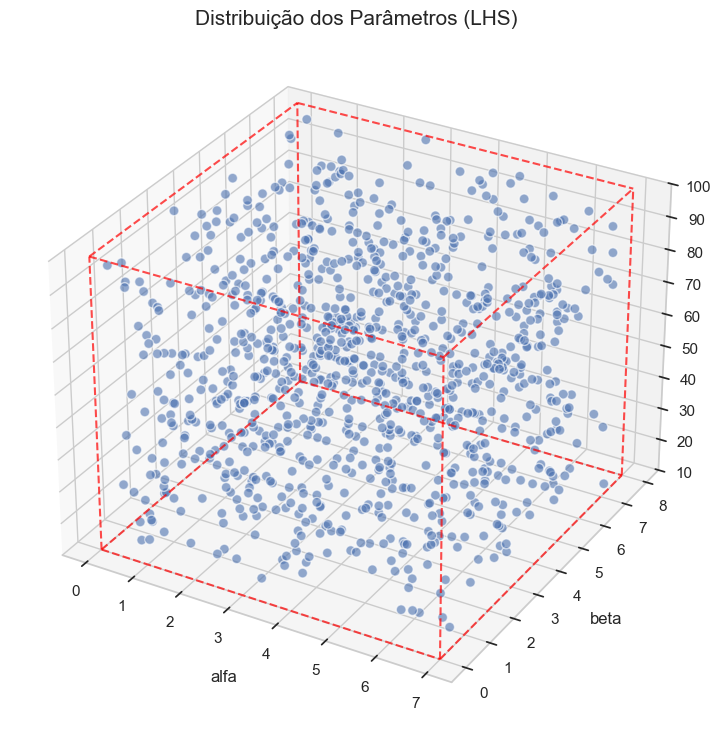

In [ ]:


# 1. Carregue seu arquivo LHS
# Substitua pelo caminho correto do seu arquivo
df = lhs_global.copy()

# 2. Configura a figura 3D
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# 3. Escolha as 3 colunas que você quer visualizar
# Exemplo com parâmetros do ACO (ajuste os nomes conforme seu CSV)
x_col = 'alfa'
y_col = 'beta'
z_col = 'n_formigas'

xs = df[x_col]
ys = df[y_col]
zs = df[z_col]

# 4. Cria o Scatter Plot
# c=zs colore os pontos baseados na altura Z para facilitar a percepção de profundidade
scatter = ax.scatter(xs, ys, zs, marker='o', alpha=0.6, edgecolors='w', s=50)

# 5. Desenhar as Linhas Delimitadoras (A Caixa do Espaço de Busca)
# Defina os limites (use min/max dos dados ou seus limites teóricos do LHS)
x_lims = [xs.min(), xs.max()]
y_lims = [ys.min(), ys.max()]
z_lims = [zs.min(), zs.max()]

# Gera todos os 8 cantos do cubo (produto cartesiano dos limites)
corners = list(product(x_lims, y_lims, z_lims))

# Percorre todos os pares de cantos e desenha linha se eles diferirem em apenas 1 dimensão
for p1, p2 in combinations(corners, 2):
    # Calcula a diferença absoluta entre os pontos
    diff = np.abs(np.array(p1) - np.array(p2))
    # Se a diferença for zero em 2 eixos e não-zero no 3º, é uma aresta do cubo
    if np.sum(diff > 0) == 1:
        ax.plot3D([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], 
                  color='red', linestyle='--', linewidth=1.5, alpha=0.7)

# Labels e Títulos
ax.set_xlabel(x_col, fontsize=11, labelpad=10)
ax.set_ylabel(y_col, fontsize=11, labelpad=10)
ax.set_zlabel(z_col, fontsize=11, labelpad=10)
ax.set_title('Espaço de Parâmetros LHS (Delimitado)', fontsize=14)

# Labels
ax.set_xlabel(x_col, fontsize=12)
ax.set_ylabel(y_col, fontsize=12)
ax.set_zlabel(z_col, fontsize=12)
ax.set_title('Distribuição dos Parâmetros (LHS)', fontsize=15)

plt.show()

In [ ]:
lhs_global

,n_formigas,alfa,beta,taxa_evaporacao,simulacao,n_populacao,taxa_crossover,taxa_mutacao,tamanho_torneio,elit_pct
0,99,5.834928,7.017131,0.302586,1,113,0.771649,0.127657,5,0.478453
1,23,4.424171,3.081911,0.412346,2,269,0.740991,0.272486,8,0.373275
2,82,0.801847,1.005034,0.485183,3,105,0.848859,0.019742,4,0.358278
3,94,0.897241,7.972453,0.418448,4,317,0.386756,0.313174,5,0.440684
4,68,3.947553,4.945379,0.143766,5,28,0.223716,0.093212,12,0.119111
...,...,...,...,...,...,...,...,...,...,...
995,23,6.338913,3.923350,0.337445,996,136,0.130028,0.066317,4,0.237543
996,44,1.511497,2.750239,0.385940,997,252,0.370221,0.238676,4,0.079846
997,93,5.061026,1.072163,0.214510,998,124,0.551494,0.112724,13,0.426948
998,100,6.220735,1.534098,0.196244,999,328,0.639316,0.074118,6,0.194202


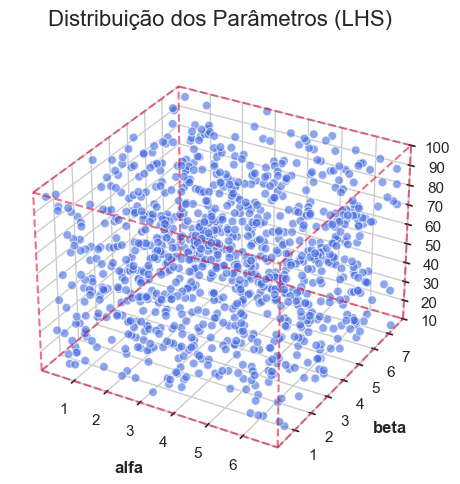

In [ ]:
# df = ... 

# Configuração da Figura
fig = plt.figure(figsize=(6, 5)) # Aumentei o tamanho para dar respiro
ax = fig.add_subplot(111, projection='3d')

# Variáveis (Exemplo baseando na sua imagem)
x_col, y_col, z_col = 'alfa', 'beta', 'n_formigas' # Chutei o nome do eixo Z pela escala
xs, ys, zs = df[x_col], df[y_col], df[z_col]

# 1. Plotagem (Adicionei s=40 para pontos levemente maiores)
ax.scatter(xs, ys, zs, c='royalblue', marker='o', alpha=0.6, s=40, edgecolors='white', linewidth=0.8)

# 2. Caixa Delimitadora (Mantida a sua lógica, apenas ajustando visual)
x_lims, y_lims, z_lims = [xs.min(), xs.max()], [ys.min(), ys.max()], [zs.min(), zs.max()]
corners = list(product(x_lims, y_lims, z_lims))
for p1, p2 in combinations(corners, 2):
    if np.sum(np.abs(np.array(p1) - np.array(p2)) > 0) == 1:
        ax.plot3D([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], 
                  color='crimson', linestyle='--', linewidth=1.5, alpha=0.6)

# --- MELHORIAS VISUAIS ---

# 3. Remover o fundo cinza das "paredes" do gráfico 3D
# Isso deixa o gráfico limpo, ideal para inserir em documentos de texto
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) # 100% transparente
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# 4. Ajuste dos Rótulos e Distância (Resolve o corte do nome)
# 'labelpad' empurra o texto para longe do eixo
ax.set_xlabel(x_col, fontsize=12, labelpad=10, fontweight='bold')
ax.set_ylabel(y_col, fontsize=12, labelpad=10, fontweight='bold')
ax.set_zlabel(z_col, fontsize=12, labelpad=15, fontweight='bold') # Pad maior no Z

ax.set_title('Distribuição dos Parâmetros (LHS)', fontsize=16, pad=20)

# Ajuste de limites para garantir que a caixa vermelha não toque na borda
ax.set_xlim(x_lims)
ax.set_ylim(y_lims)
ax.set_zlim(z_lims)




plt.tight_layout()

# dpi=300 garante alta resolução para impressão/PDF
# transparent=True remove o fundo branco da figura
#plt.savefig('lhs_distribuicao_clean.png', transparent=True, dpi=300)

plt.show()

In [ ]:


# 1. Carregue seu arquivo LHS

# 2. Configura a figura 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 3. Defina as colunas
x_col, y_col, z_col = 'alfa', 'beta', 'taxa_evaporacao'
xs, ys, zs = df[x_col], df[y_col], df[z_col]

# 4. Scatter Plot (Sem variação de cor pela taxa de evaporação)
ax.scatter(xs, ys, zs, c='royalblue', marker='o', alpha=0.5, s=30, edgecolors='k', linewidth=0.5)

# 5. Desenhar as Linhas Delimitadoras (A Caixa do Espaço de Busca)
# Defina os limites (use min/max dos dados ou seus limites teóricos do LHS)
x_lims = [xs.min(), xs.max()]
y_lims = [ys.min(), ys.max()]
z_lims = [zs.min(), zs.max()]

# Gera todos os 8 cantos do cubo (produto cartesiano dos limites)
corners = list(product(x_lims, y_lims, z_lims))

# Percorre todos os pares de cantos e desenha linha se eles diferirem em apenas 1 dimensão
for p1, p2 in combinations(corners, 2):
    # Calcula a diferença absoluta entre os pontos
    diff = np.abs(np.array(p1) - np.array(p2))
    # Se a diferença for zero em 2 eixos e não-zero no 3º, é uma aresta do cubo
    if np.sum(diff > 0) == 1:
        ax.plot3D([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], 
                  color='red', linestyle='--', linewidth=1.5, alpha=0.7)

# Labels e Títulos
ax.set_xlabel(x_col, fontsize=11, labelpad=10)
ax.set_ylabel(y_col, fontsize=11, labelpad=10)
ax.set_zlabel(z_col, fontsize=11, labelpad=10)
ax.set_title('Espaço de Parâmetros LHS (Delimitado)', fontsize=14)

# Ajusta a visão para não cortar as linhas
ax.set_xlim(x_lims)
ax.set_ylim(y_lims)
ax.set_zlim(z_lims)

plt.tight_layout()
plt.show()

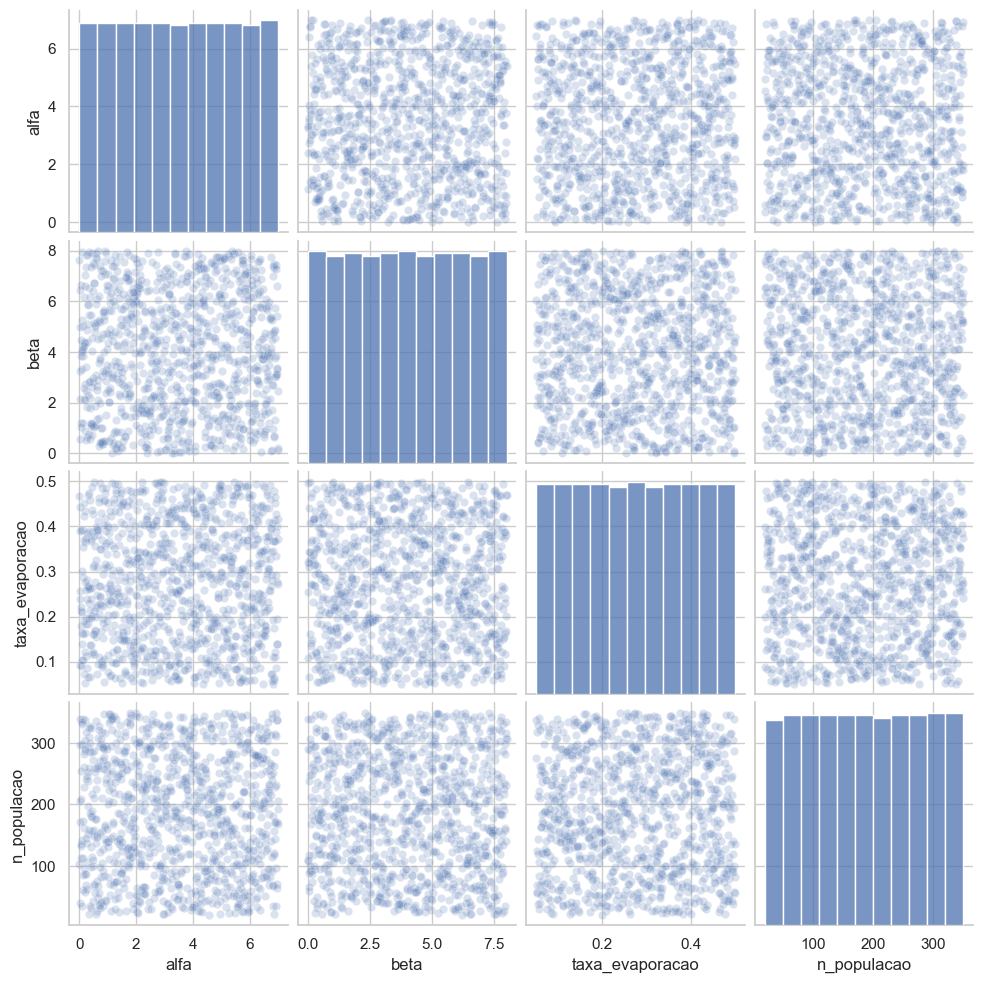

In [ ]:
# Selecione apenas as colunas de parâmetros (ignore IDs ou resultados por enquanto)
colunas_params = ['alfa', 'beta', 'taxa_evaporacao', 'n_populacao']
sns.pairplot(df[colunas_params], diag_kind='hist', plot_kws={'alpha': 0.2})
plt.show()